In [39]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

class FlexibleDecoder(nn.Module):
    def __init__(self, latent_dim=2, data_dim=2, hidden_dim=128, kl_weight=0.01):
        super().__init__()
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.kl_weight = kl_weight
        
        # Flexible decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def decode(self, z):
        """Decode latent vectors to distribution parameters"""
        outputs = self.decoder(z)
        return outputs
    
    def prior_log_prob(self, z):
        """Compute log probability under standard normal prior"""
        return Normal(0, 1).log_prob(z).sum(-1)
    
    def reconstruction_log_prob(self, x, z):
        """Compute log probability of x under the decoder distribution"""
        mean = self.decode(z)   
        dist = Normal(mean, torch.ones_like(mean))
        return dist.log_prob(x).mean(-1)

    def reconstruction_loss(self, x, z):
        """Compute reconstruction loss using MSE"""
        mean = self.decode(z)
        return torch.mean((x - mean) ** 2, dim=-1)
    
    def compute_loss(self, x, z):
        recon_loss = self.reconstruction_loss(x, z)
        prior_log_prob = self.prior_log_prob(z)
        return (recon_loss - self.kl_weight * prior_log_prob).mean()
    
    def infer_latent(self, x, n_steps=20, lr=0.1):
        """Infer latent z for given x using gradient descent"""
        z = torch.randn(x.shape[0], self.latent_dim, requires_grad=True)
        optimizer = torch.optim.Adam([z], lr=lr)
        
        for _ in range(n_steps):
            optimizer.zero_grad()
            loss = self.compute_loss(x, z)
            loss.backward()
            optimizer.step()
            
        return z.detach()
    
    def sample(self, n_samples):
        """Generate samples from the model"""
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim)
            mean = self.decode(z)
            # noise = torch.randn_like(mean)
            return mean
    
    def reconstruct(self, x):
        """Reconstruct data from the model"""
        with torch.no_grad():
            z = self.infer_latent(x)
            mean = self.decode(z)
            # noise = torch.randn_like(mean)
            return mean

# Generate Swiss roll data
n_samples = 1000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
X = X[:, [0, 2]]  # Take only 2D projection
X = torch.FloatTensor(X)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Create and train model
latent_dim = 2
data_dim = 2
hidden_dim = 128
kl_weight = 0.1
model = FlexibleDecoder(latent_dim=latent_dim, data_dim=data_dim, hidden_dim=hidden_dim, kl_weight=kl_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [40]:
# Training loop
"""
Algorithm (latex, Math):

$$
\begin{aligned}
for i = 0, 1, ..., n_batches:
    for j = 0, 1, ..., n_inference_steps:
        z = z - \eta_z \nabla_z \mathcal{L}(x, d_{\theta}(z))
    \theta = \theta - \eta_{\theta} \nabla_{\theta} \mathcal{L}(x, d_{\theta}(z))
\end{aligned}
$$
"""
n_epochs = 1000
batch_size = 128
n_batches = len(X) // batch_size

for epoch in range(n_epochs):
    # Shuffle data
    indices = torch.randperm(len(X))
    epoch_loss = 0
    
    for i in range(n_batches):
        optimizer.zero_grad()
        
        # Get mini-batch
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        X_batch = X[batch_indices]
        
        # Infer latents
        model.eval()
        z = model.infer_latent(X_batch, n_steps=20, lr=0.1)
        model.train()
        
        # Compute loss
        # loss = model.compute_loss(X_batch, z)
        loss = model.compute_loss(X_batch, z.detach())

        # Alternative loss formulation:
        # recon_log_prob = model.reconstruction_log_prob(X_batch, z)
        # prior_log_prob = model.prior_log_prob(z)
        # loss = -(recon_log_prob + prior_log_prob).mean()
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/n_batches:.4f}')



Epoch 100/1000, Loss: 0.5870
Epoch 200/1000, Loss: 0.4695
Epoch 300/1000, Loss: 0.4335
Epoch 400/1000, Loss: 0.4480
Epoch 500/1000, Loss: 0.4260
Epoch 600/1000, Loss: 0.4126
Epoch 700/1000, Loss: 0.4039
Epoch 800/1000, Loss: 0.4091
Epoch 900/1000, Loss: 0.4029
Epoch 1000/1000, Loss: 0.4276


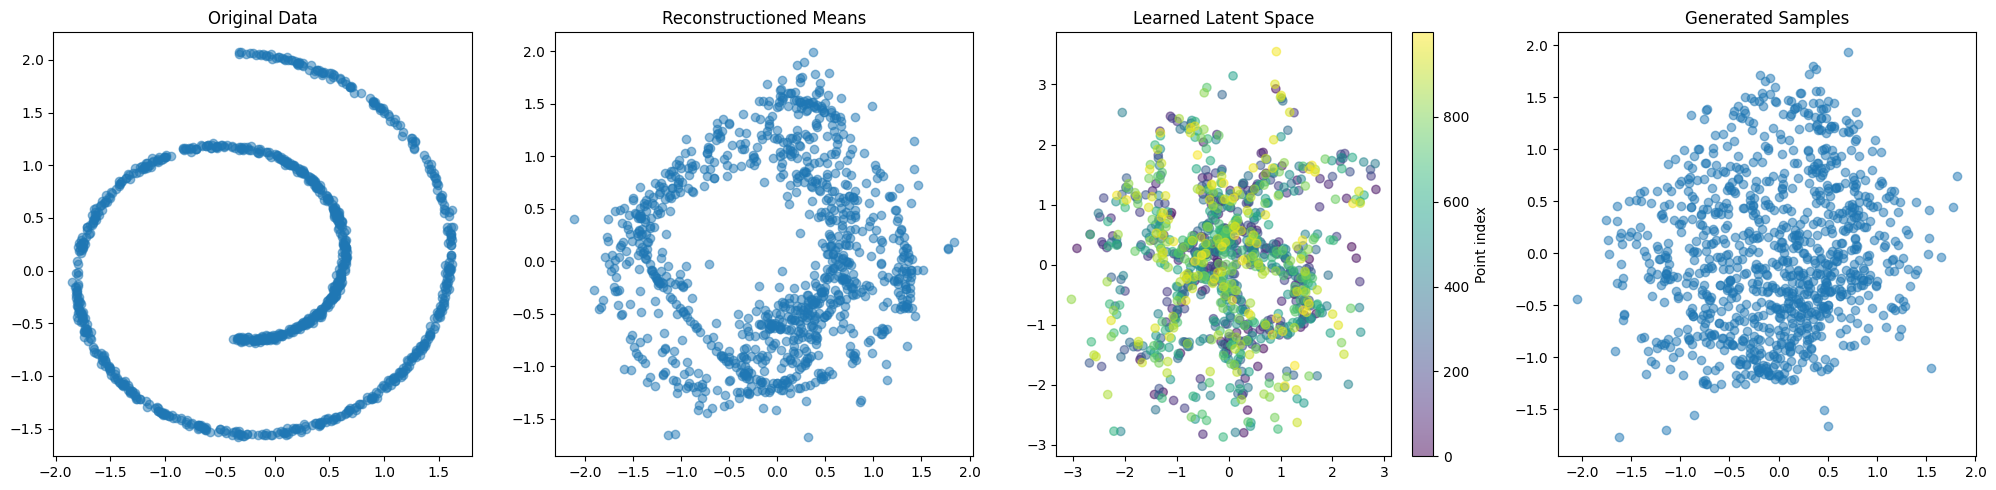

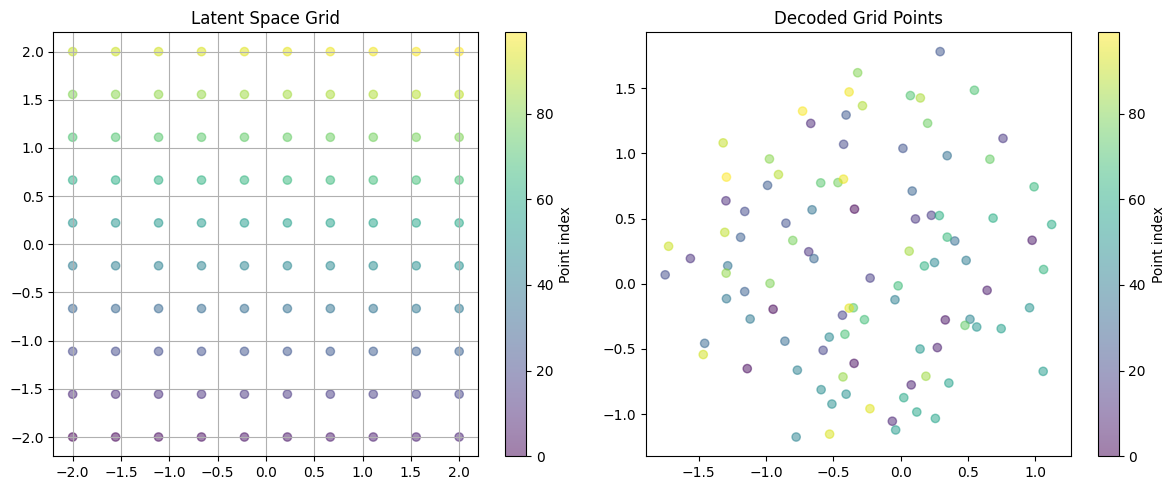

In [41]:
def visualize_model(X, model):
    plt.figure(figsize=(20, 5))
    
    # Plot original data
    plt.subplot(141)
    plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), alpha=0.5)
    plt.title('Original Data')
    
    # Plot reconstructions
    plt.subplot(142)
    z = model.infer_latent(X)
    mean = model.decode(z)
    plt.scatter(mean[:, 0].detach().numpy(), 
                mean[:, 1].detach().numpy(), 
                alpha=0.5)
    plt.title('Reconstructioned Means')
    
    if latent_dim == 2: 
        # Plot latent space
        plt.subplot(143)
        plt.scatter(z[:, 0].numpy(), z[:, 1].numpy(), 
                c=np.arange(len(z)), cmap='viridis', alpha=0.5)
        plt.colorbar(label='Point index')
        plt.title('Learned Latent Space')
    
    # Plot generated samples
    plt.subplot(144)
    samples = model.sample(n_samples=1000)
    plt.scatter(samples[:, 0].detach().numpy(), 
                samples[:, 1].detach().numpy(), 
                alpha=0.5)
    plt.title('Generated Samples')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_model(X, model)

# Demonstrate latent space interpolation
def interpolate_latent_space(model, n_points=10):
    # Create a grid in latent space
    x = np.linspace(-2, 2, n_points)
    y = np.linspace(-2, 2, n_points)
    xx, yy = np.meshgrid(x, y)
    
    # Convert to latent vectors
    z = torch.FloatTensor(np.stack([xx.ravel(), yy.ravel()], axis=1))
    
    # Decode
    with torch.no_grad():
        mean = model.decode(z)
    
    # Create color mapping
    colors = np.arange(len(z))
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Plot latent grid
    plt.subplot(121)
    plt.scatter(z[:, 0], z[:, 1], c=colors, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Point index')
    plt.title('Latent Space Grid')
    plt.grid(True)
    
    # Plot decoded points
    plt.subplot(122)
    plt.scatter(mean[:, 0], mean[:, 1], c=colors, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Point index')
    plt.title('Decoded Grid Points')
    
    plt.tight_layout()
    plt.show()

# Show latent space interpolation
if latent_dim == 2:
    interpolate_latent_space(model)


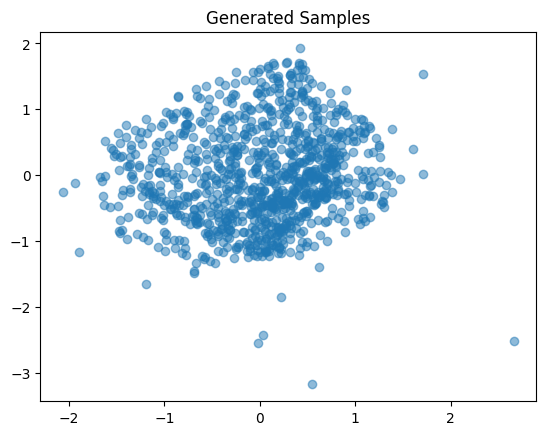

In [42]:
with torch.no_grad():
    samples = model.sample(n_samples=1000)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title('Generated Samples')
    plt.show()


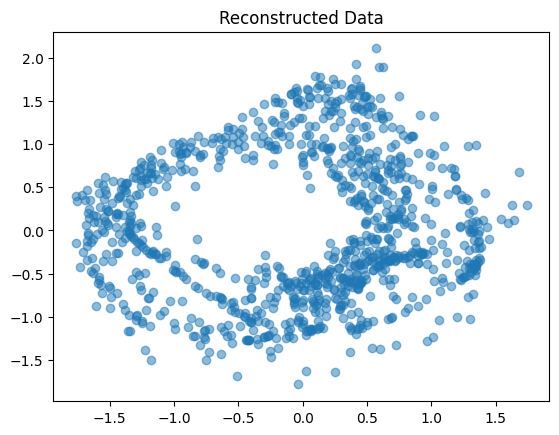

In [43]:
# reconstructed_X = model.reconstruct(X)
z = model.infer_latent(X)
mean = model.decode(z)
# Add noise according to the mathematical formulation
noise = torch.randn_like(mean) * 0
reconstructed_X = (mean + noise).detach().numpy()
plt.scatter(reconstructed_X[:, 0], reconstructed_X[:, 1], alpha=0.5)
plt.title('Reconstructed Data')
plt.show()
